In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones

from numpy.random import randn
from numpy.random import randint

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras.datasets.fashion_mnist import load_data

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Embedding, Concatenate

In [24]:
# discriminator model

def define_discriminator(in_shape = (28,28,1), n_classes = 10):
  
  in_label = Input(shape = (1,))
  li = Embedding(n_classes, 50)(in_label)

  n_nodes = in_shape[0] * in_shape[1]
  li = Dense(n_nodes)(li)
  li = Reshape((in_shape[0], in_shape[1], 1))(li)
 
  in_image = Input(shape=in_shape)
 
  merge = Concatenate()([in_image, li])

  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
  fe = LeakyReLU(alpha=0.2)(fe)

  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)(fe)

  fe = Flatten()(fe)

  fe = Dropout(0.4)(fe)

  out_layer = Dense(1, activation='sigmoid')(fe)

  model = Model([in_image, in_label], out_layer)

  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [25]:
d = define_discriminator()
d.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28, 2)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       2432      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dropout_1 (Dropout)         (None, 6272)              0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [4]:
# generator model

def define_generator(latent_dim, n_classes = 10):

  in_label = Input(shape = (1,))
  li = Embedding(n_classes, 50)(in_label)

  n_nodes = 7*7
  li = Dense(n_nodes)(li)
  li = Reshape((7,7,1))(li)

  in_lat = Input(shape = (latent_dim,))

  n_nodes = 128 * 7*7
  gen = Dense(n_nodes)(in_lat)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Reshape((7,7,128))(gen)

  merge = Concatenate()([gen, li])

  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
  gen = LeakyReLU(alpha=0.2)(gen)

  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen)

  out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)

  model = Model([in_lat, in_label], out_layer)
  return model

In [5]:
g = define_generator(1)
g.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 6272)         12544       ['input_4[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_3[0][0]']                
                                                                                            

In [6]:
# define GAN

def define_gan(g_model, d_model):

	d_model.trainable = False

	gen_noise, gen_label = g_model.input

	gen_output = g_model.output

	gan_output = d_model([gen_output, gen_label])

	model = Model([gen_noise, gen_label], gan_output)

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [7]:
def load_real_samples():

  (trainX, trainy), (_, _) = load_data()

  X = expand_dims(trainX, axis=-1)

  X = X.astype('float32')

  X = (X - 127.5) / 127.5

  print("Shape: X.shape",X.shape)
  return [X, trainy]

In [8]:
img,lab = load_real_samples() 

4431872/4422102 [==============================] - 0s 0us/step
Shape: X.shape (60000, 28, 28, 1)


In [22]:
def label_image():

  #label input
  in_label = Input(shape = (1,))
  li = Embedding(10, 50)(in_label)

  n_nodes = 28 * 28
  li = Dense(n_nodes)(li)
  li = Reshape((28, 28, 1))(li)
 
  in_image = Input(shape=(28,28,1))
 
  merge = Concatenate()([in_image, li])

  model = Model(inputs = [in_image, in_label], outputs = merge)
  return model

In [9]:
def generate_real_samples(dataset, n_samples):

	images, labels = dataset

	ix = randint(0, images.shape[0], n_samples)

	X, labels = images[ix], labels[ix]

	y = ones((n_samples, 1))
	return [X, labels], y

In [11]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):

	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)

	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [15]:
def generate_fake_samples(generator, latent_dim, n_samples):

	z_input, labels_input = generate_latent_points(latent_dim, n_samples)

	images = generator.predict([z_input, labels_input])

	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [16]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):

	[images, labels_input], y = generate_fake_samples(g_model, latent_dim, n_samples)

	images = (images + 1) / 2.0

	for i in range(10 * 10):

		plt.subplot(10, 10, 1 + i)

		plt.axis('off')

		plt.imshow(images[i, :, :, 0], cmap='gray_r')
		
	plt.show()

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)

  for i in range(n_epochs):

    for j in range(bat_per_epo):

      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)

      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
	
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

      y_gan = ones((n_batch, 1))

      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

      
      if ((j+1) % bat_per_epo == 0):
        print("value of j is:",j+1)
        summarize_performance(i,g_model,latent_dim)
   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Shape: X.shape (60000, 28, 28, 1)
>1, 1/468, d1=0.687, d2=0.696 g=0.691
>1, 2/468, d1=0.630, d2=0.700 g=0.688
>1, 3/468, d1=0.568, d2=0.705 g=0.683
>1, 4/468, d1=0.523, d2=0.710 g=0.681
>1, 5/468, d1=0.477, d2=0.712 g=0.681
>1, 6/468, d1=0.415, d2=0.713 g=0.685
>1, 7/468, d1=0.368, d2=0.707 g=0.693
>1, 8/468, d1=0.308, d2=0.702 g=0.699
>1, 9/468, d1=0.258, d2=0.711 g=0.693
>1, 10/468, d1=0.228, d2=0.741 g=0.671
>1, 11/468, d1=0.195, d2=0.791 g=0.637
>1, 12/468, d1=0.163, d2=0.845 g=0.607
>1, 13/468, d1=0.163, d2=0.896 g=0.592
>1, 14/468, d1=0.159, d2=0.914 g=0.602
>1, 15/468, d1=0.175, d2=0.901 g=0.635
>1, 16/468, d1=0.188, d2=0.833 g=0.715
>1, 17/468, d1=0.215, d2=0.718 g=0.840
>1, 18/468, d1=0.284, d2=0.597 g=0.976
>1, 19/468, d1=0.293, d2=0.502 g=1.119
>1, 20/468, d1=0.255, d2=0.410 g=1.254
>1, 21/468, d1=0.402, d2=0.414 g=1.192
>1, 22/468, d1=0.424, d2=0.516 g=0.998
>1, 23/468, d1=0.284, d2=0.616 g=0.851
>1, 24/468, d1=0.324, d2=0.779 g=0.687
>1, 25/468, d1=0.219, d2=0.955 g=0.576


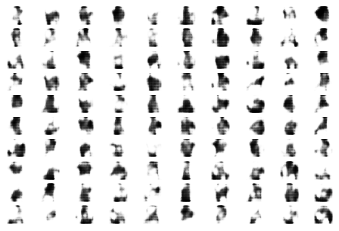

>2, 1/468, d1=0.712, d2=0.647 g=0.795
>2, 2/468, d1=0.692, d2=0.666 g=0.776
>2, 3/468, d1=0.689, d2=0.669 g=0.776
>2, 4/468, d1=0.689, d2=0.660 g=0.752
>2, 5/468, d1=0.708, d2=0.671 g=0.760
>2, 6/468, d1=0.696, d2=0.679 g=0.753
>2, 7/468, d1=0.640, d2=0.677 g=0.737
>2, 8/468, d1=0.668, d2=0.685 g=0.758
>2, 9/468, d1=0.657, d2=0.684 g=0.738
>2, 10/468, d1=0.689, d2=0.673 g=0.732
>2, 11/468, d1=0.661, d2=0.699 g=0.764
>2, 12/468, d1=0.660, d2=0.666 g=0.761
>2, 13/468, d1=0.726, d2=0.667 g=0.776
>2, 14/468, d1=0.678, d2=0.654 g=0.763
>2, 15/468, d1=0.659, d2=0.669 g=0.781
>2, 16/468, d1=0.694, d2=0.683 g=0.763
>2, 17/468, d1=0.671, d2=0.648 g=0.786
>2, 18/468, d1=0.673, d2=0.661 g=0.767
>2, 19/468, d1=0.656, d2=0.653 g=0.765
>2, 20/468, d1=0.692, d2=0.656 g=0.775
>2, 21/468, d1=0.690, d2=0.644 g=0.793
>2, 22/468, d1=0.648, d2=0.652 g=0.786
>2, 23/468, d1=0.691, d2=0.636 g=0.777
>2, 24/468, d1=0.665, d2=0.660 g=0.787
>2, 25/468, d1=0.647, d2=0.670 g=0.779
>2, 26/468, d1=0.645, d2=0.654 g=0

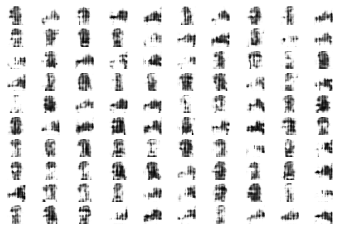

>3, 1/468, d1=0.573, d2=0.599 g=0.905
>3, 2/468, d1=0.656, d2=0.601 g=0.867
>3, 3/468, d1=0.665, d2=0.627 g=0.833
>3, 4/468, d1=0.658, d2=0.684 g=0.781
>3, 5/468, d1=0.648, d2=0.715 g=0.733
>3, 6/468, d1=0.622, d2=0.767 g=0.741
>3, 7/468, d1=0.691, d2=0.746 g=0.722
>3, 8/468, d1=0.672, d2=0.739 g=0.726
>3, 9/468, d1=0.667, d2=0.748 g=0.770
>3, 10/468, d1=0.640, d2=0.716 g=0.788
>3, 11/468, d1=0.653, d2=0.672 g=0.807
>3, 12/468, d1=0.680, d2=0.644 g=0.781
>3, 13/468, d1=0.681, d2=0.678 g=0.752
>3, 14/468, d1=0.646, d2=0.733 g=0.752
>3, 15/468, d1=0.650, d2=0.730 g=0.729
>3, 16/468, d1=0.676, d2=0.720 g=0.762
>3, 17/468, d1=0.710, d2=0.713 g=0.750
>3, 18/468, d1=0.680, d2=0.694 g=0.741
>3, 19/468, d1=0.681, d2=0.711 g=0.744
>3, 20/468, d1=0.660, d2=0.672 g=0.764
>3, 21/468, d1=0.703, d2=0.680 g=0.792
>3, 22/468, d1=0.733, d2=0.649 g=0.781
>3, 23/468, d1=0.697, d2=0.674 g=0.806
>3, 24/468, d1=0.672, d2=0.646 g=0.816
>3, 25/468, d1=0.677, d2=0.681 g=0.786
>3, 26/468, d1=0.664, d2=0.685 g=0

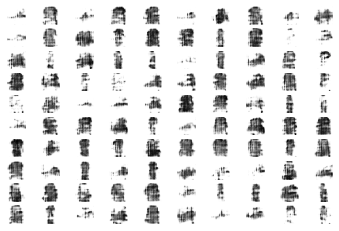

>4, 1/468, d1=0.673, d2=0.642 g=0.799
>4, 2/468, d1=0.640, d2=0.628 g=0.801
>4, 3/468, d1=0.647, d2=0.665 g=0.799
>4, 4/468, d1=0.680, d2=0.663 g=0.780
>4, 5/468, d1=0.686, d2=0.697 g=0.736
>4, 6/468, d1=0.635, d2=0.706 g=0.724
>4, 7/468, d1=0.666, d2=0.719 g=0.733
>4, 8/468, d1=0.664, d2=0.725 g=0.731
>4, 9/468, d1=0.650, d2=0.699 g=0.747
>4, 10/468, d1=0.662, d2=0.684 g=0.772
>4, 11/468, d1=0.672, d2=0.646 g=0.773
>4, 12/468, d1=0.633, d2=0.648 g=0.796
>4, 13/468, d1=0.695, d2=0.653 g=0.801
>4, 14/468, d1=0.679, d2=0.624 g=0.794
>4, 15/468, d1=0.683, d2=0.636 g=0.806
>4, 16/468, d1=0.675, d2=0.647 g=0.784
>4, 17/468, d1=0.688, d2=0.652 g=0.776
>4, 18/468, d1=0.639, d2=0.680 g=0.773
>4, 19/468, d1=0.639, d2=0.666 g=0.755
>4, 20/468, d1=0.625, d2=0.675 g=0.770
>4, 21/468, d1=0.669, d2=0.657 g=0.757
>4, 22/468, d1=0.676, d2=0.647 g=0.771
>4, 23/468, d1=0.656, d2=0.655 g=0.783
>4, 24/468, d1=0.676, d2=0.645 g=0.779
>4, 25/468, d1=0.641, d2=0.648 g=0.780
>4, 26/468, d1=0.614, d2=0.665 g=0

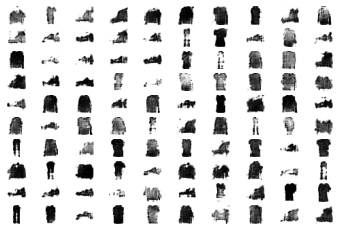

>5, 1/468, d1=0.696, d2=0.614 g=0.833
>5, 2/468, d1=0.695, d2=0.647 g=0.805
>5, 3/468, d1=0.708, d2=0.638 g=0.806
>5, 4/468, d1=0.670, d2=0.669 g=0.777
>5, 5/468, d1=0.704, d2=0.644 g=0.798
>5, 6/468, d1=0.663, d2=0.628 g=0.779
>5, 7/468, d1=0.710, d2=0.651 g=0.787
>5, 8/468, d1=0.680, d2=0.630 g=0.792
>5, 9/468, d1=0.676, d2=0.620 g=0.802
>5, 10/468, d1=0.643, d2=0.641 g=0.805
>5, 11/468, d1=0.676, d2=0.680 g=0.786
>5, 12/468, d1=0.641, d2=0.679 g=0.758
>5, 13/468, d1=0.682, d2=0.709 g=0.763
>5, 14/468, d1=0.678, d2=0.698 g=0.757
>5, 15/468, d1=0.675, d2=0.686 g=0.798
>5, 16/468, d1=0.691, d2=0.627 g=0.804
>5, 17/468, d1=0.721, d2=0.619 g=0.815
>5, 18/468, d1=0.679, d2=0.617 g=0.806
>5, 19/468, d1=0.674, d2=0.652 g=0.823
>5, 20/468, d1=0.685, d2=0.654 g=0.807
>5, 21/468, d1=0.700, d2=0.670 g=0.769
>5, 22/468, d1=0.687, d2=0.673 g=0.746
>5, 23/468, d1=0.703, d2=0.678 g=0.747
>5, 24/468, d1=0.710, d2=0.687 g=0.764
>5, 25/468, d1=0.686, d2=0.654 g=0.768
>5, 26/468, d1=0.647, d2=0.628 g=0

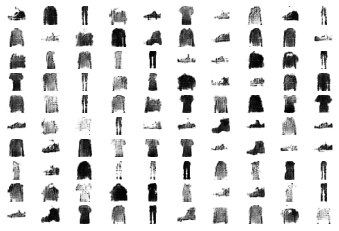

>6, 1/468, d1=0.680, d2=0.701 g=0.763
>6, 2/468, d1=0.664, d2=0.652 g=0.755
>6, 3/468, d1=0.639, d2=0.652 g=0.744
>6, 4/468, d1=0.672, d2=0.655 g=0.756
>6, 5/468, d1=0.681, d2=0.668 g=0.769
>6, 6/468, d1=0.679, d2=0.696 g=0.756
>6, 7/468, d1=0.692, d2=0.664 g=0.763
>6, 8/468, d1=0.657, d2=0.665 g=0.781
>6, 9/468, d1=0.683, d2=0.669 g=0.760
>6, 10/468, d1=0.663, d2=0.622 g=0.787
>6, 11/468, d1=0.672, d2=0.650 g=0.799
>6, 12/468, d1=0.669, d2=0.650 g=0.777
>6, 13/468, d1=0.678, d2=0.661 g=0.774
>6, 14/468, d1=0.657, d2=0.671 g=0.775
>6, 15/468, d1=0.701, d2=0.670 g=0.778
>6, 16/468, d1=0.663, d2=0.669 g=0.755
>6, 17/468, d1=0.679, d2=0.685 g=0.769
>6, 18/468, d1=0.663, d2=0.650 g=0.772
>6, 19/468, d1=0.653, d2=0.666 g=0.775
>6, 20/468, d1=0.677, d2=0.660 g=0.758
>6, 21/468, d1=0.662, d2=0.661 g=0.768
>6, 22/468, d1=0.660, d2=0.687 g=0.746
>6, 23/468, d1=0.670, d2=0.660 g=0.780
>6, 24/468, d1=0.704, d2=0.652 g=0.786
>6, 25/468, d1=0.701, d2=0.654 g=0.810
>6, 26/468, d1=0.688, d2=0.642 g=0

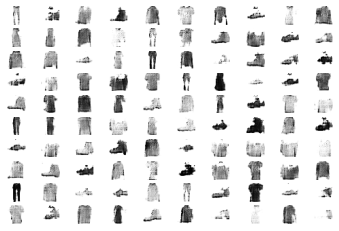

>7, 1/468, d1=0.619, d2=0.647 g=0.837
>7, 2/468, d1=0.657, d2=0.688 g=0.809
>7, 3/468, d1=0.647, d2=0.665 g=0.777
>7, 4/468, d1=0.668, d2=0.759 g=0.738
>7, 5/468, d1=0.585, d2=0.767 g=0.748
>7, 6/468, d1=0.661, d2=0.704 g=0.749
>7, 7/468, d1=0.681, d2=0.656 g=0.788
>7, 8/468, d1=0.684, d2=0.641 g=0.841
>7, 9/468, d1=0.682, d2=0.629 g=0.852
>7, 10/468, d1=0.697, d2=0.634 g=0.856
>7, 11/468, d1=0.698, d2=0.655 g=0.788
>7, 12/468, d1=0.709, d2=0.689 g=0.756
>7, 13/468, d1=0.694, d2=0.687 g=0.759
>7, 14/468, d1=0.659, d2=0.657 g=0.791
>7, 15/468, d1=0.679, d2=0.654 g=0.820
>7, 16/468, d1=0.639, d2=0.616 g=0.850
>7, 17/468, d1=0.636, d2=0.624 g=0.853
>7, 18/468, d1=0.634, d2=0.665 g=0.798
>7, 19/468, d1=0.633, d2=0.711 g=0.752
>7, 20/468, d1=0.677, d2=0.699 g=0.726
>7, 21/468, d1=0.657, d2=0.730 g=0.761
>7, 22/468, d1=0.663, d2=0.694 g=0.803
>7, 23/468, d1=0.681, d2=0.611 g=0.885
>7, 24/468, d1=0.666, d2=0.558 g=0.930
>7, 25/468, d1=0.696, d2=0.589 g=0.896
>7, 26/468, d1=0.681, d2=0.601 g=0

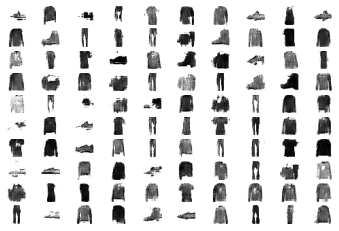

>8, 1/468, d1=0.657, d2=0.648 g=0.773
>8, 2/468, d1=0.675, d2=0.676 g=0.762
>8, 3/468, d1=0.634, d2=0.682 g=0.764
>8, 4/468, d1=0.638, d2=0.661 g=0.785
>8, 5/468, d1=0.647, d2=0.678 g=0.771
>8, 6/468, d1=0.649, d2=0.656 g=0.806
>8, 7/468, d1=0.679, d2=0.652 g=0.793
>8, 8/468, d1=0.667, d2=0.659 g=0.797
>8, 9/468, d1=0.668, d2=0.672 g=0.769
>8, 10/468, d1=0.665, d2=0.676 g=0.782
>8, 11/468, d1=0.666, d2=0.683 g=0.770
>8, 12/468, d1=0.674, d2=0.649 g=0.792
>8, 13/468, d1=0.643, d2=0.650 g=0.795
>8, 14/468, d1=0.672, d2=0.649 g=0.769
>8, 15/468, d1=0.673, d2=0.667 g=0.767
>8, 16/468, d1=0.681, d2=0.674 g=0.775
>8, 17/468, d1=0.664, d2=0.688 g=0.767
>8, 18/468, d1=0.664, d2=0.633 g=0.809
>8, 19/468, d1=0.682, d2=0.652 g=0.793
>8, 20/468, d1=0.684, d2=0.640 g=0.782
>8, 21/468, d1=0.664, d2=0.625 g=0.763
>8, 22/468, d1=0.640, d2=0.667 g=0.762
>8, 23/468, d1=0.670, d2=0.709 g=0.761
>8, 24/468, d1=0.660, d2=0.683 g=0.777
>8, 25/468, d1=0.646, d2=0.667 g=0.803
>8, 26/468, d1=0.633, d2=0.648 g=0

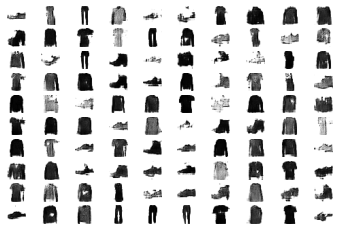

>9, 1/468, d1=0.681, d2=0.666 g=0.816
>9, 2/468, d1=0.658, d2=0.631 g=0.849
>9, 3/468, d1=0.695, d2=0.585 g=0.823
>9, 4/468, d1=0.731, d2=0.616 g=0.831
>9, 5/468, d1=0.702, d2=0.676 g=0.735
>9, 6/468, d1=0.657, d2=0.734 g=0.756
>9, 7/468, d1=0.647, d2=0.681 g=0.773
>9, 8/468, d1=0.655, d2=0.693 g=0.784
>9, 9/468, d1=0.653, d2=0.618 g=0.803
>9, 10/468, d1=0.629, d2=0.655 g=0.812
>9, 11/468, d1=0.611, d2=0.674 g=0.750
>9, 12/468, d1=0.652, d2=0.703 g=0.772
>9, 13/468, d1=0.688, d2=0.766 g=0.741
>9, 14/468, d1=0.680, d2=0.682 g=0.792
>9, 15/468, d1=0.682, d2=0.635 g=0.822
>9, 16/468, d1=0.683, d2=0.609 g=0.913
>9, 17/468, d1=0.714, d2=0.617 g=0.865
>9, 18/468, d1=0.675, d2=0.629 g=0.815
>9, 19/468, d1=0.717, d2=0.650 g=0.766
>9, 20/468, d1=0.706, d2=0.688 g=0.748
>9, 21/468, d1=0.679, d2=0.654 g=0.780
>9, 22/468, d1=0.680, d2=0.670 g=0.780
>9, 23/468, d1=0.636, d2=0.657 g=0.821
>9, 24/468, d1=0.659, d2=0.634 g=0.801
>9, 25/468, d1=0.638, d2=0.685 g=0.752
>9, 26/468, d1=0.602, d2=0.728 g=0

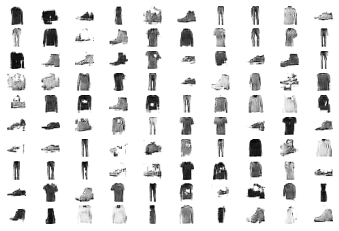

>10, 1/468, d1=0.685, d2=0.636 g=0.791
>10, 2/468, d1=0.635, d2=0.646 g=0.824
>10, 3/468, d1=0.658, d2=0.657 g=0.777
>10, 4/468, d1=0.645, d2=0.648 g=0.770
>10, 5/468, d1=0.652, d2=0.709 g=0.748
>10, 6/468, d1=0.640, d2=0.686 g=0.731
>10, 7/468, d1=0.648, d2=0.686 g=0.737
>10, 8/468, d1=0.713, d2=0.689 g=0.796
>10, 9/468, d1=0.669, d2=0.688 g=0.816
>10, 10/468, d1=0.677, d2=0.625 g=0.841
>10, 11/468, d1=0.680, d2=0.641 g=0.842
>10, 12/468, d1=0.659, d2=0.650 g=0.774
>10, 13/468, d1=0.675, d2=0.653 g=0.754
>10, 14/468, d1=0.684, d2=0.694 g=0.773
>10, 15/468, d1=0.661, d2=0.681 g=0.752
>10, 16/468, d1=0.665, d2=0.636 g=0.795
>10, 17/468, d1=0.670, d2=0.638 g=0.793
>10, 18/468, d1=0.634, d2=0.661 g=0.777
>10, 19/468, d1=0.697, d2=0.704 g=0.748
>10, 20/468, d1=0.655, d2=0.699 g=0.744
>10, 21/468, d1=0.619, d2=0.653 g=0.791
>10, 22/468, d1=0.665, d2=0.680 g=0.783
>10, 23/468, d1=0.666, d2=0.669 g=0.819
>10, 24/468, d1=0.677, d2=0.638 g=0.783
>10, 25/468, d1=0.667, d2=0.651 g=0.776
>10, 26/4

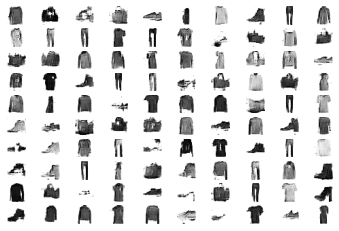

>11, 1/468, d1=0.655, d2=0.699 g=0.775
>11, 2/468, d1=0.693, d2=0.657 g=0.785
>11, 3/468, d1=0.660, d2=0.654 g=0.808
>11, 4/468, d1=0.666, d2=0.662 g=0.830
>11, 5/468, d1=0.674, d2=0.646 g=0.818
>11, 6/468, d1=0.683, d2=0.641 g=0.796
>11, 7/468, d1=0.695, d2=0.664 g=0.764
>11, 8/468, d1=0.691, d2=0.663 g=0.773
>11, 9/468, d1=0.692, d2=0.629 g=0.775
>11, 10/468, d1=0.660, d2=0.654 g=0.751
>11, 11/468, d1=0.642, d2=0.636 g=0.740
>11, 12/468, d1=0.645, d2=0.716 g=0.750
>11, 13/468, d1=0.662, d2=0.710 g=0.763
>11, 14/468, d1=0.658, d2=0.693 g=0.778
>11, 15/468, d1=0.657, d2=0.664 g=0.783
>11, 16/468, d1=0.647, d2=0.629 g=0.786
>11, 17/468, d1=0.676, d2=0.642 g=0.809
>11, 18/468, d1=0.657, d2=0.649 g=0.783
>11, 19/468, d1=0.664, d2=0.668 g=0.756
>11, 20/468, d1=0.679, d2=0.674 g=0.755
>11, 21/468, d1=0.687, d2=0.690 g=0.756
>11, 22/468, d1=0.673, d2=0.689 g=0.763
>11, 23/468, d1=0.649, d2=0.664 g=0.760
>11, 24/468, d1=0.695, d2=0.674 g=0.743
>11, 25/468, d1=0.662, d2=0.662 g=0.746
>11, 26/4

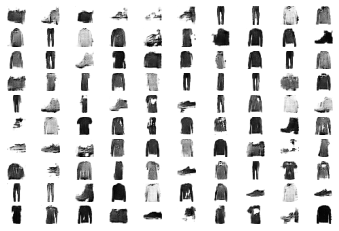

>12, 1/468, d1=0.675, d2=0.706 g=0.750
>12, 2/468, d1=0.667, d2=0.673 g=0.757
>12, 3/468, d1=0.698, d2=0.688 g=0.742
>12, 4/468, d1=0.668, d2=0.656 g=0.754
>12, 5/468, d1=0.679, d2=0.678 g=0.754
>12, 6/468, d1=0.683, d2=0.698 g=0.766
>12, 7/468, d1=0.624, d2=0.687 g=0.754
>12, 8/468, d1=0.658, d2=0.643 g=0.777
>12, 9/468, d1=0.693, d2=0.682 g=0.782
>12, 10/468, d1=0.702, d2=0.657 g=0.763
>12, 11/468, d1=0.675, d2=0.684 g=0.757
>12, 12/468, d1=0.666, d2=0.650 g=0.784
>12, 13/468, d1=0.665, d2=0.649 g=0.763
>12, 14/468, d1=0.641, d2=0.666 g=0.753
>12, 15/468, d1=0.640, d2=0.679 g=0.764
>12, 16/468, d1=0.702, d2=0.707 g=0.777
>12, 17/468, d1=0.651, d2=0.655 g=0.773
>12, 18/468, d1=0.664, d2=0.663 g=0.762
>12, 19/468, d1=0.657, d2=0.692 g=0.771
>12, 20/468, d1=0.667, d2=0.669 g=0.751
>12, 21/468, d1=0.625, d2=0.693 g=0.790
>12, 22/468, d1=0.672, d2=0.708 g=0.759
>12, 23/468, d1=0.711, d2=0.662 g=0.760
>12, 24/468, d1=0.677, d2=0.732 g=0.759
>12, 25/468, d1=0.628, d2=0.668 g=0.774
>12, 26/4

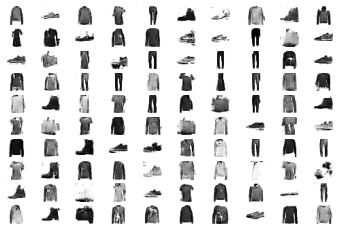

>13, 1/468, d1=0.706, d2=0.685 g=0.773
>13, 2/468, d1=0.663, d2=0.650 g=0.756
>13, 3/468, d1=0.646, d2=0.671 g=0.779
>13, 4/468, d1=0.671, d2=0.632 g=0.814
>13, 5/468, d1=0.703, d2=0.642 g=0.840
>13, 6/468, d1=0.683, d2=0.672 g=0.740
>13, 7/468, d1=0.695, d2=0.674 g=0.784
>13, 8/468, d1=0.678, d2=0.671 g=0.778
>13, 9/468, d1=0.693, d2=0.662 g=0.796
>13, 10/468, d1=0.670, d2=0.661 g=0.789
>13, 11/468, d1=0.652, d2=0.653 g=0.812
>13, 12/468, d1=0.672, d2=0.683 g=0.810
>13, 13/468, d1=0.698, d2=0.678 g=0.765
>13, 14/468, d1=0.665, d2=0.663 g=0.768
>13, 15/468, d1=0.689, d2=0.636 g=0.778
>13, 16/468, d1=0.657, d2=0.657 g=0.802
>13, 17/468, d1=0.704, d2=0.647 g=0.783
>13, 18/468, d1=0.714, d2=0.680 g=0.800
>13, 19/468, d1=0.674, d2=0.652 g=0.800
>13, 20/468, d1=0.692, d2=0.660 g=0.760
>13, 21/468, d1=0.690, d2=0.685 g=0.765
>13, 22/468, d1=0.680, d2=0.665 g=0.764
>13, 23/468, d1=0.652, d2=0.673 g=0.792
>13, 24/468, d1=0.670, d2=0.652 g=0.753
>13, 25/468, d1=0.688, d2=0.677 g=0.775
>13, 26/4

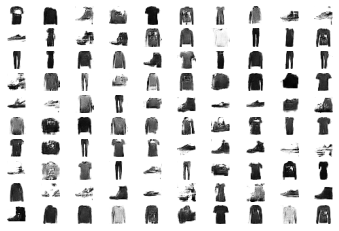

>14, 1/468, d1=0.669, d2=0.652 g=0.782
>14, 2/468, d1=0.660, d2=0.686 g=0.746
>14, 3/468, d1=0.711, d2=0.648 g=0.749
>14, 4/468, d1=0.710, d2=0.663 g=0.762
>14, 5/468, d1=0.717, d2=0.652 g=0.741
>14, 6/468, d1=0.657, d2=0.669 g=0.763
>14, 7/468, d1=0.664, d2=0.658 g=0.750
>14, 8/468, d1=0.637, d2=0.656 g=0.755
>14, 9/468, d1=0.658, d2=0.680 g=0.747
>14, 10/468, d1=0.653, d2=0.691 g=0.737
>14, 11/468, d1=0.690, d2=0.673 g=0.751
>14, 12/468, d1=0.676, d2=0.658 g=0.779
>14, 13/468, d1=0.690, d2=0.661 g=0.820
>14, 14/468, d1=0.714, d2=0.677 g=0.786
>14, 15/468, d1=0.637, d2=0.702 g=0.782
>14, 16/468, d1=0.642, d2=0.679 g=0.761
>14, 17/468, d1=0.664, d2=0.687 g=0.773
>14, 18/468, d1=0.673, d2=0.693 g=0.774
>14, 19/468, d1=0.690, d2=0.652 g=0.850
>14, 20/468, d1=0.676, d2=0.621 g=0.843
>14, 21/468, d1=0.679, d2=0.624 g=0.828
>14, 22/468, d1=0.730, d2=0.666 g=0.802
>14, 23/468, d1=0.711, d2=0.657 g=0.749
>14, 24/468, d1=0.699, d2=0.662 g=0.789
>14, 25/468, d1=0.663, d2=0.657 g=0.819
>14, 26/4

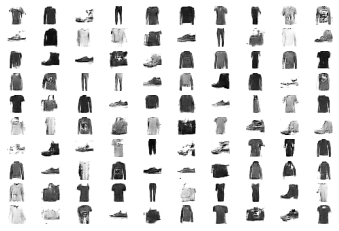

>15, 1/468, d1=0.684, d2=0.650 g=0.780
>15, 2/468, d1=0.652, d2=0.674 g=0.783
>15, 3/468, d1=0.669, d2=0.692 g=0.737
>15, 4/468, d1=0.693, d2=0.629 g=0.747
>15, 5/468, d1=0.636, d2=0.668 g=0.786
>15, 6/468, d1=0.684, d2=0.634 g=0.789
>15, 7/468, d1=0.684, d2=0.690 g=0.794
>15, 8/468, d1=0.668, d2=0.651 g=0.783
>15, 9/468, d1=0.682, d2=0.688 g=0.764
>15, 10/468, d1=0.681, d2=0.673 g=0.749
>15, 11/468, d1=0.675, d2=0.699 g=0.759
>15, 12/468, d1=0.689, d2=0.677 g=0.806
>15, 13/468, d1=0.674, d2=0.645 g=0.803
>15, 14/468, d1=0.661, d2=0.611 g=0.813
>15, 15/468, d1=0.670, d2=0.698 g=0.757
>15, 16/468, d1=0.730, d2=0.721 g=0.721
>15, 17/468, d1=0.651, d2=0.697 g=0.763
>15, 18/468, d1=0.612, d2=0.662 g=0.803
>15, 19/468, d1=0.654, d2=0.650 g=0.804
>15, 20/468, d1=0.695, d2=0.645 g=0.876
>15, 21/468, d1=0.729, d2=0.700 g=0.747
>15, 22/468, d1=0.685, d2=0.711 g=0.770
>15, 23/468, d1=0.672, d2=0.655 g=0.810
>15, 24/468, d1=0.695, d2=0.650 g=0.821
>15, 25/468, d1=0.633, d2=0.724 g=0.778
>15, 26/4

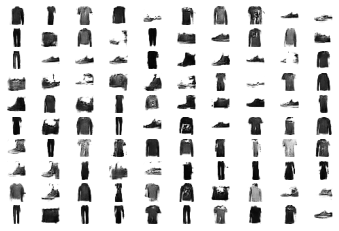

>16, 1/468, d1=0.681, d2=0.709 g=0.768
>16, 2/468, d1=0.704, d2=0.649 g=0.801
>16, 3/468, d1=0.670, d2=0.617 g=0.779
>16, 4/468, d1=0.668, d2=0.638 g=0.823
>16, 5/468, d1=0.697, d2=0.663 g=0.780
>16, 6/468, d1=0.681, d2=0.670 g=0.766
>16, 7/468, d1=0.686, d2=0.672 g=0.759
>16, 8/468, d1=0.676, d2=0.687 g=0.760
>16, 9/468, d1=0.688, d2=0.632 g=0.772
>16, 10/468, d1=0.637, d2=0.686 g=0.762
>16, 11/468, d1=0.707, d2=0.679 g=0.768
>16, 12/468, d1=0.690, d2=0.696 g=0.759
>16, 13/468, d1=0.690, d2=0.642 g=0.785
>16, 14/468, d1=0.661, d2=0.648 g=0.782
>16, 15/468, d1=0.653, d2=0.649 g=0.776
>16, 16/468, d1=0.664, d2=0.665 g=0.771
>16, 17/468, d1=0.698, d2=0.657 g=0.790
>16, 18/468, d1=0.698, d2=0.679 g=0.759
>16, 19/468, d1=0.655, d2=0.660 g=0.761
>16, 20/468, d1=0.657, d2=0.662 g=0.788
>16, 21/468, d1=0.658, d2=0.649 g=0.782
>16, 22/468, d1=0.669, d2=0.650 g=0.770
>16, 23/468, d1=0.675, d2=0.678 g=0.760
>16, 24/468, d1=0.668, d2=0.662 g=0.778
>16, 25/468, d1=0.655, d2=0.673 g=0.753
>16, 26/4

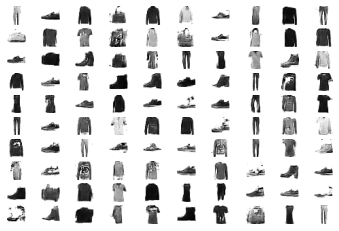

>17, 1/468, d1=0.683, d2=0.666 g=0.781
>17, 2/468, d1=0.664, d2=0.660 g=0.780
>17, 3/468, d1=0.663, d2=0.691 g=0.737
>17, 4/468, d1=0.649, d2=0.680 g=0.781
>17, 5/468, d1=0.647, d2=0.639 g=0.771
>17, 6/468, d1=0.712, d2=0.651 g=0.794
>17, 7/468, d1=0.676, d2=0.688 g=0.781
>17, 8/468, d1=0.670, d2=0.663 g=0.772
>17, 9/468, d1=0.672, d2=0.623 g=0.781
>17, 10/468, d1=0.667, d2=0.687 g=0.759
>17, 11/468, d1=0.699, d2=0.668 g=0.766
>17, 12/468, d1=0.684, d2=0.675 g=0.742
>17, 13/468, d1=0.661, d2=0.697 g=0.748
>17, 14/468, d1=0.672, d2=0.662 g=0.776
>17, 15/468, d1=0.654, d2=0.686 g=0.758
>17, 16/468, d1=0.692, d2=0.662 g=0.748
>17, 17/468, d1=0.678, d2=0.688 g=0.762
>17, 18/468, d1=0.676, d2=0.676 g=0.748
>17, 19/468, d1=0.658, d2=0.673 g=0.772
>17, 20/468, d1=0.685, d2=0.674 g=0.765
>17, 21/468, d1=0.665, d2=0.668 g=0.794
>17, 22/468, d1=0.721, d2=0.694 g=0.772
>17, 23/468, d1=0.664, d2=0.695 g=0.768
>17, 24/468, d1=0.678, d2=0.693 g=0.779
>17, 25/468, d1=0.661, d2=0.653 g=0.780
>17, 26/4

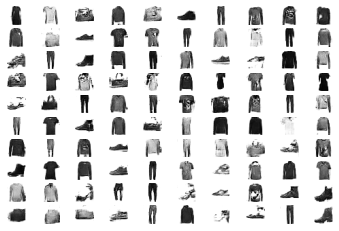

>18, 1/468, d1=0.672, d2=0.630 g=0.805
>18, 2/468, d1=0.699, d2=0.643 g=0.812
>18, 3/468, d1=0.671, d2=0.659 g=0.801
>18, 4/468, d1=0.701, d2=0.658 g=0.783
>18, 5/468, d1=0.657, d2=0.683 g=0.774
>18, 6/468, d1=0.651, d2=0.650 g=0.788
>18, 7/468, d1=0.714, d2=0.656 g=0.811
>18, 8/468, d1=0.704, d2=0.663 g=0.785
>18, 9/468, d1=0.705, d2=0.660 g=0.746
>18, 10/468, d1=0.636, d2=0.688 g=0.739
>18, 11/468, d1=0.653, d2=0.668 g=0.776
>18, 12/468, d1=0.676, d2=0.674 g=0.790
>18, 13/468, d1=0.697, d2=0.616 g=0.809
>18, 14/468, d1=0.681, d2=0.612 g=0.802
>18, 15/468, d1=0.683, d2=0.655 g=0.764
>18, 16/468, d1=0.679, d2=0.705 g=0.752
>18, 17/468, d1=0.666, d2=0.660 g=0.774
>18, 18/468, d1=0.685, d2=0.660 g=0.779
>18, 19/468, d1=0.660, d2=0.641 g=0.792
>18, 20/468, d1=0.672, d2=0.668 g=0.775
>18, 21/468, d1=0.685, d2=0.683 g=0.784
>18, 22/468, d1=0.653, d2=0.677 g=0.755
>18, 23/468, d1=0.627, d2=0.644 g=0.768
>18, 24/468, d1=0.639, d2=0.680 g=0.788
>18, 25/468, d1=0.676, d2=0.693 g=0.767
>18, 26/4

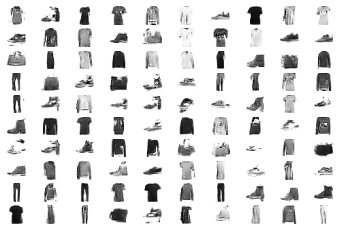

>19, 1/468, d1=0.691, d2=0.685 g=0.792
>19, 2/468, d1=0.700, d2=0.662 g=0.758
>19, 3/468, d1=0.669, d2=0.679 g=0.757
>19, 4/468, d1=0.655, d2=0.662 g=0.763
>19, 5/468, d1=0.672, d2=0.679 g=0.748
>19, 6/468, d1=0.709, d2=0.689 g=0.775
>19, 7/468, d1=0.674, d2=0.651 g=0.797
>19, 8/468, d1=0.705, d2=0.636 g=0.809
>19, 9/468, d1=0.674, d2=0.670 g=0.776
>19, 10/468, d1=0.686, d2=0.689 g=0.779
>19, 11/468, d1=0.709, d2=0.686 g=0.755
>19, 12/468, d1=0.695, d2=0.652 g=0.769
>19, 13/468, d1=0.679, d2=0.645 g=0.764
>19, 14/468, d1=0.659, d2=0.660 g=0.797
>19, 15/468, d1=0.657, d2=0.699 g=0.778
>19, 16/468, d1=0.661, d2=0.699 g=0.770
>19, 17/468, d1=0.619, d2=0.629 g=0.772
>19, 18/468, d1=0.681, d2=0.631 g=0.796
>19, 19/468, d1=0.659, d2=0.640 g=0.811
>19, 20/468, d1=0.700, d2=0.691 g=0.769
>19, 21/468, d1=0.701, d2=0.667 g=0.756
>19, 22/468, d1=0.675, d2=0.667 g=0.762
>19, 23/468, d1=0.711, d2=0.659 g=0.768
>19, 24/468, d1=0.673, d2=0.661 g=0.792
>19, 25/468, d1=0.646, d2=0.653 g=0.746
>19, 26/4

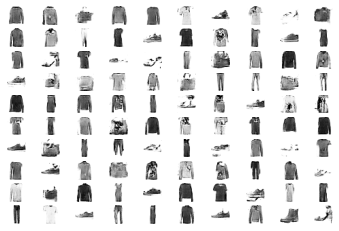

>20, 1/468, d1=0.642, d2=0.656 g=0.845
>20, 2/468, d1=0.674, d2=0.690 g=0.786
>20, 3/468, d1=0.647, d2=0.657 g=0.793
>20, 4/468, d1=0.676, d2=0.670 g=0.771
>20, 5/468, d1=0.640, d2=0.639 g=0.769
>20, 6/468, d1=0.675, d2=0.694 g=0.773
>20, 7/468, d1=0.673, d2=0.665 g=0.786
>20, 8/468, d1=0.676, d2=0.680 g=0.799
>20, 9/468, d1=0.719, d2=0.676 g=0.803
>20, 10/468, d1=0.645, d2=0.664 g=0.802
>20, 11/468, d1=0.681, d2=0.648 g=0.788
>20, 12/468, d1=0.696, d2=0.652 g=0.779
>20, 13/468, d1=0.688, d2=0.645 g=0.782
>20, 14/468, d1=0.693, d2=0.683 g=0.789
>20, 15/468, d1=0.708, d2=0.665 g=0.771
>20, 16/468, d1=0.695, d2=0.682 g=0.764
>20, 17/468, d1=0.646, d2=0.662 g=0.750
>20, 18/468, d1=0.674, d2=0.676 g=0.771
>20, 19/468, d1=0.674, d2=0.670 g=0.778
>20, 20/468, d1=0.648, d2=0.645 g=0.774
>20, 21/468, d1=0.677, d2=0.664 g=0.793
>20, 22/468, d1=0.706, d2=0.666 g=0.765
>20, 23/468, d1=0.671, d2=0.685 g=0.769
>20, 24/468, d1=0.683, d2=0.669 g=0.780
>20, 25/468, d1=0.661, d2=0.637 g=0.791
>20, 26/4

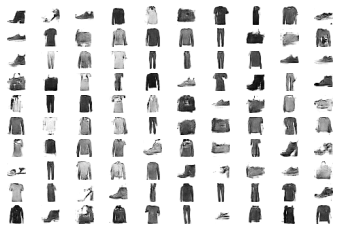

>21, 1/468, d1=0.637, d2=0.665 g=0.777
>21, 2/468, d1=0.650, d2=0.681 g=0.767
>21, 3/468, d1=0.690, d2=0.677 g=0.775
>21, 4/468, d1=0.691, d2=0.655 g=0.761
>21, 5/468, d1=0.688, d2=0.670 g=0.758
>21, 6/468, d1=0.631, d2=0.684 g=0.770
>21, 7/468, d1=0.646, d2=0.664 g=0.781
>21, 8/468, d1=0.668, d2=0.648 g=0.758
>21, 9/468, d1=0.645, d2=0.663 g=0.769
>21, 10/468, d1=0.683, d2=0.681 g=0.779
>21, 11/468, d1=0.673, d2=0.670 g=0.785
>21, 12/468, d1=0.690, d2=0.673 g=0.773
>21, 13/468, d1=0.692, d2=0.676 g=0.767
>21, 14/468, d1=0.647, d2=0.672 g=0.783
>21, 15/468, d1=0.683, d2=0.654 g=0.768
>21, 16/468, d1=0.688, d2=0.650 g=0.766
>21, 17/468, d1=0.676, d2=0.669 g=0.762
>21, 18/468, d1=0.697, d2=0.672 g=0.791
>21, 19/468, d1=0.659, d2=0.648 g=0.769
>21, 20/468, d1=0.653, d2=0.639 g=0.803
>21, 21/468, d1=0.663, d2=0.660 g=0.782
>21, 22/468, d1=0.683, d2=0.688 g=0.755
>21, 23/468, d1=0.691, d2=0.693 g=0.752
>21, 24/468, d1=0.651, d2=0.652 g=0.752
>21, 25/468, d1=0.660, d2=0.684 g=0.796
>21, 26/4

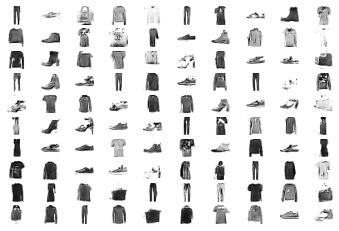

>22, 1/468, d1=0.668, d2=0.631 g=0.795
>22, 2/468, d1=0.665, d2=0.622 g=0.792
>22, 3/468, d1=0.694, d2=0.690 g=0.786
>22, 4/468, d1=0.677, d2=0.676 g=0.786
>22, 5/468, d1=0.701, d2=0.681 g=0.793
>22, 6/468, d1=0.672, d2=0.666 g=0.787
>22, 7/468, d1=0.674, d2=0.629 g=0.813
>22, 8/468, d1=0.655, d2=0.648 g=0.791
>22, 9/468, d1=0.688, d2=0.653 g=0.787
>22, 10/468, d1=0.747, d2=0.647 g=0.773
>22, 11/468, d1=0.724, d2=0.653 g=0.786
>22, 12/468, d1=0.686, d2=0.637 g=0.774
>22, 13/468, d1=0.633, d2=0.662 g=0.780
>22, 14/468, d1=0.666, d2=0.673 g=0.729
>22, 15/468, d1=0.657, d2=0.675 g=0.738
>22, 16/468, d1=0.682, d2=0.646 g=0.771
>22, 17/468, d1=0.679, d2=0.692 g=0.777
>22, 18/468, d1=0.673, d2=0.662 g=0.791
>22, 19/468, d1=0.671, d2=0.667 g=0.758
>22, 20/468, d1=0.688, d2=0.692 g=0.818
>22, 21/468, d1=0.676, d2=0.668 g=0.749
>22, 22/468, d1=0.710, d2=0.679 g=0.776
>22, 23/468, d1=0.690, d2=0.666 g=0.763
>22, 24/468, d1=0.646, d2=0.684 g=0.774
>22, 25/468, d1=0.672, d2=0.688 g=0.760
>22, 26/4

KeyboardInterrupt: ignored

In [ ]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim) 